In [1]:
import pandas as pd
import json
import sodapy
from sodapy import Socrata
import numpy as np
import seaborn as sns

In [2]:
#import data DOB_Job_Application_Filings
data_url='data.cityofnewyork.us'
data_set='ic3t-wcy2'
app_token=('pjWUHEIdlOXdcS6TyIjGaKBny')
job= Socrata(data_url,app_token)
job.timeout = 60
job_result = job.get(data_set,limit= 2000000, select="Borough,Zip,DOBRunDate,State",where="State='NY' and DOBRunDate between '2020-04-01T00:00:00.000' and '2020-05-01T00:00:00.000'")
df_job = pd.DataFrame.from_records(job_result)
df_job=df_job.loc[df_job['Zip'].notnull()]
df_job=df_job.loc[df_job['Zip'].astype(int)>= 10000] #take out non new york data by zip code
df_job=df_job.loc[df_job['Zip'].astype(int)<= 11999]
df_job.to_csv("job.csv")
df_job.head()
#print(df_job.shape)

,Borough,DOBRunDate,State,Zip
0,MANHATTAN,2020-04-01T00:00:00.000,NY,10023
1,BROOKLYN,2020-04-01T00:00:00.000,NY,11215
2,BROOKLYN,2020-04-01T00:00:00.000,NY,11209
3,STATEN ISLAND,2020-04-01T00:00:00.000,NY,11101
4,MANHATTAN,2020-04-01T00:00:00.000,NY,10801


In [5]:
#import data DOB Complaints Received
data_url='data.cityofnewyork.us'
data_set='eabe-havv'
app_token=('pjWUHEIdlOXdcS6TyIjGaKBny')
complaint= Socrata(data_url,app_token)
complaint.timeout = 60
complaint_result = complaint.get(data_set,limit= 2000000, select="Date_Entered,Zip_Code,House_Street",where="Date_Entered between '04/01/2020' and '05/01/2020'")
df_complaint = pd.DataFrame.from_records(complaint_result)
df_complaint = df_complaint.rename(columns={'Zip_Code':'Zip'}) #change the name to same as job data
df_complaint=df_complaint.loc[df_complaint['Zip'].notnull()]
df_complaint=df_complaint.loc[df_complaint['Zip']>= '10000']
df_complaint=df_complaint.loc[df_complaint['Zip']<= '11999']
df_complaint=df_complaint.loc[df_complaint['Date_Entered'].apply(lambda x: x[6:10]) == '2020']

df_complaint.to_csv("complaint.csv")
df_complaint.head()
#print(df_complaint.shape)


,Date_Entered,House_Street,Zip
0,04/01/2020,HYATT STREET,10301
1,04/01/2020,203 STREET,11360
2,04/01/2020,165 STREET,11434
3,04/01/2020,BROOKLYN AVENUE,11210
4,04/01/2020,STARR STREET,11385


In [6]:
#aggregate how many job application each day in each zip code
#df_job.groupby(["Zip","Date"]).size().to_frame('count_job').reset_index().head(20)
df_jobbyDay = df_job.groupby(["DOBRunDate","Zip"]).size().to_frame('count_job').reset_index()
df_jobbyDay['Date'] = df_jobbyDay['DOBRunDate'].str[:10] #make a new colum for formulated date
df_jobbyDay.head()

,DOBRunDate,Zip,count_job,Date
0,2020-04-01T00:00:00.000,10001,4,2020-04-01
1,2020-04-01T00:00:00.000,10003,3,2020-04-01
2,2020-04-01T00:00:00.000,10004,3,2020-04-01
3,2020-04-01T00:00:00.000,10005,1,2020-04-01
4,2020-04-01T00:00:00.000,10007,1,2020-04-01


In [7]:
#aggregate how many complaints each day in each zip code
#df_complaint.groupby(["Date","Zip"]).size().to_frame('count_complaint').reset_index().head(20)
df_complaintbyDay = df_complaint.groupby(["Zip","Date_Entered"]).size().to_frame('count_complaint').reset_index()

#print(type(df_complaintbyDay['Date_Entered'][0])) 
df_complaintbyDay['Date']=df_complaintbyDay['Date_Entered'].apply(lambda x: x[6:] + '-' + x[0:2] + '-' + x[3:5] ) #convert the data into the same format as job file
df_complaintbyDay.head()

,Zip,Date_Entered,count_complaint,Date
0,10001,04/01/2020,1,2020-04-01
1,10001,04/02/2020,6,2020-04-02
2,10001,04/03/2020,16,2020-04-03
3,10001,04/06/2020,18,2020-04-06
4,10001,04/07/2020,10,2020-04-07


In [8]:
#merge two data set
df_jobbyDay['Zip']=df_jobbyDay['Zip'].astype(int)
df_complaintbyDay['Zip']=df_complaintbyDay['Zip'].astype(int)
mergejob_complaint = pd.merge(df_jobbyDay, df_complaintbyDay,on=["Zip","Date"],how='inner')
mergejob_complaint.to_csv('mergejob_complaint.csv')

mergejob_complaint.head()

,DOBRunDate,Zip,count_job,Date,Date_Entered,count_complaint
0,2020-04-01T00:00:00.000,10001,4,2020-04-01,04/01/2020,1
1,2020-04-01T00:00:00.000,10003,3,2020-04-01,04/01/2020,5
2,2020-04-01T00:00:00.000,10007,1,2020-04-01,04/01/2020,5
3,2020-04-01T00:00:00.000,10009,3,2020-04-01,04/01/2020,9
4,2020-04-01T00:00:00.000,10011,1,2020-04-01,04/01/2020,3


In [9]:
#graph

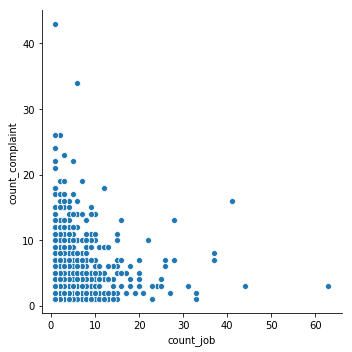

In [10]:
sns.relplot(x='count_job', y="count_complaint", data=mergejob_complaint)


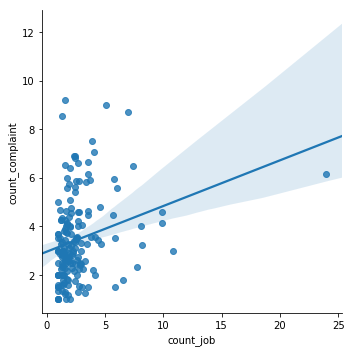

In [31]:
mergejob_complaint=mergejob_complaint.groupby(['Zip']).agg({'count_job':'mean', 'count_complaint':'mean'}) #calculate the mean of each zip area 
mergejob_complaint=mergejob_complaint.loc[mergejob_complaint['count_job'].astype(int)< 50] #remove outeliner for job
mergejob_complaint=mergejob_complaint.loc[mergejob_complaint['count_complaint'].astype(int)< 40] #remove outeliner for job
sns.lmplot(x='count_job', y="count_complaint", data=mergejob_complaint)